<a href="https://colab.research.google.com/github/41monster/AI_Courses/blob/main/Convolution_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks


**Created By: Sangam Khanal**

## Importing necessary libraries:

1. We will be using `numpy` for mathematical calculations
2. We will be using `pytorch` for neural networks
3. We will be using `matplotlib` for visualization.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# downloading lenna image from wikipedia
!wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png

--2024-05-29 16:31:34--  https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘Lenna_(test_image).png.1’

Lenna_(test_image). 100%[===================>] 462.73K  --.-KB/s    in 0.08s   

2024-05-29 16:31:34 (5.63 MB/s) - ‘Lenna_(test_image).png.1’ saved [473831/473831]



In the code below:
1. We open the Lena image we downloaded from the internet
2. OpenCV uses BGR format, so we change it to RGB Format

Text(0.5, 1.0, 'GrayScale Image (channels = 1)')

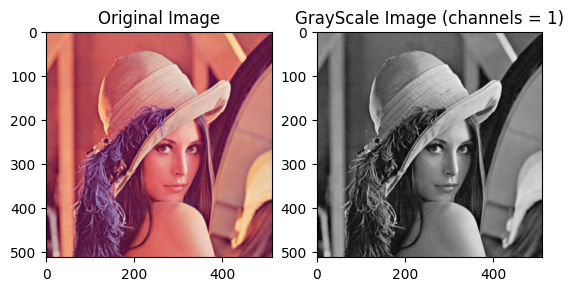

In [ ]:
import cv2 # this module used just to load the image
img = cv2.imread("/content/Lenna_(test_image).png", cv2.IMREAD_UNCHANGED)
img = img[:,:,::-1]

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(img_gray, cmap = 'gray')
ax[1].set_title("GrayScale Image (channels = 1)")

## Computing Cross Correlation

Using the formula:
$$
(X*K)(i,j) = \sum_{h}\sum_{w} X[i+h,j+w] K[h,w]
$$

In [ ]:
def corr2d(X,K):
    """
    A slower implementation of Cross-Correlation. Doing exactly as the formula
    """
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            for h_lp in range(h):
                for w_lp in range(w):
                    Y[i,j] += X[i+h_lp, j+w_lp]*K[h_lp,w_lp]
    return Y

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
def corr2d(X, K):
    """A somewhat faster implementation.
    In this implementation, we take benifit of the fact that pytorch(and numpy too)
    does elementwise multiplication if we multiply two matrices of same shape.

    We'll do an even faster implementation later.
    """
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
K = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]])
X = torch.from_numpy(img_gray)
print(f"Shape of K: {K.shape} \n Shape of X: {X.shape}")

Shape of K: torch.Size([3, 3]) 
 Shape of X: torch.Size([512, 512])


## Seeing Convolutions in Action

Here, we are using the correlation function that we created which is very slow.

Still, let's look at some of the properties:

1. Notice that in all the cases, the Kernel always sums to 1 or the output will not be a weighted average.

In the first example, look at the matrix, vertically there is a gradient, negative, zero, positive which is a certain change. And edge is also a change. So, the weighted sum will identify the edges.

<img src = "https://i.stack.imgur.com/Ntd2e.png" width = "400">

**So, with different kernels we can extract different types of features from the image.**<br>
**This implies that learning a Kernel is important**

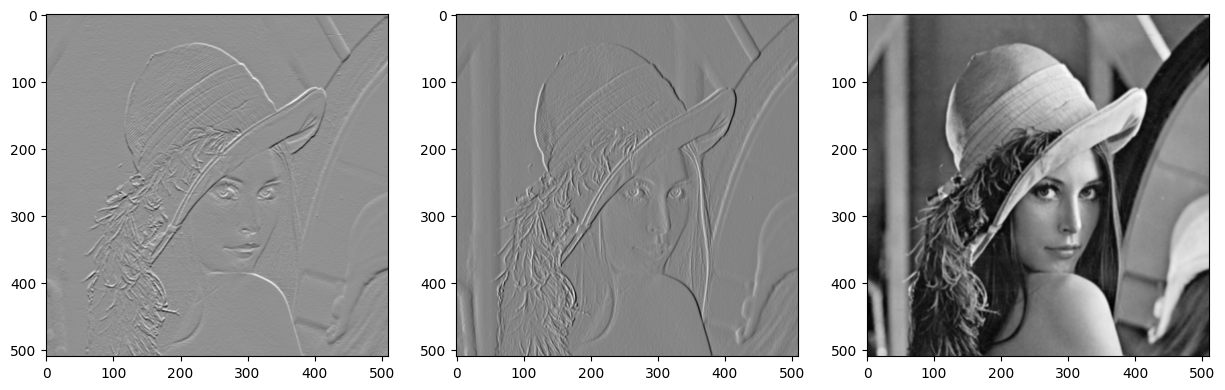

In [ ]:
K = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]]) # Edge detection Kernels (Vertical Edges)
output = corr2d(X,K)
plt.rcParams["figure.figsize"] = (15,9)
fig, ax = plt.subplots(1,3)
ax[0].imshow(output, cmap = 'gray')
output = corr2d(X,K.T) # Edge detection Kernels, (Horizontal Edges)
ax[1].imshow(output, cmap = 'gray')
K = torch.tensor([[1,1,1],[1,1,1],[1,1,1]]) /9 # 3x3 Box Filter
output = corr2d(X,K)
ax[2].imshow(output, cmap = 'gray')
plt.show()

### Questions to think about
 What kind of Kernel would produce Gaussian Blur ?

 How would you change the intensity of that blur?



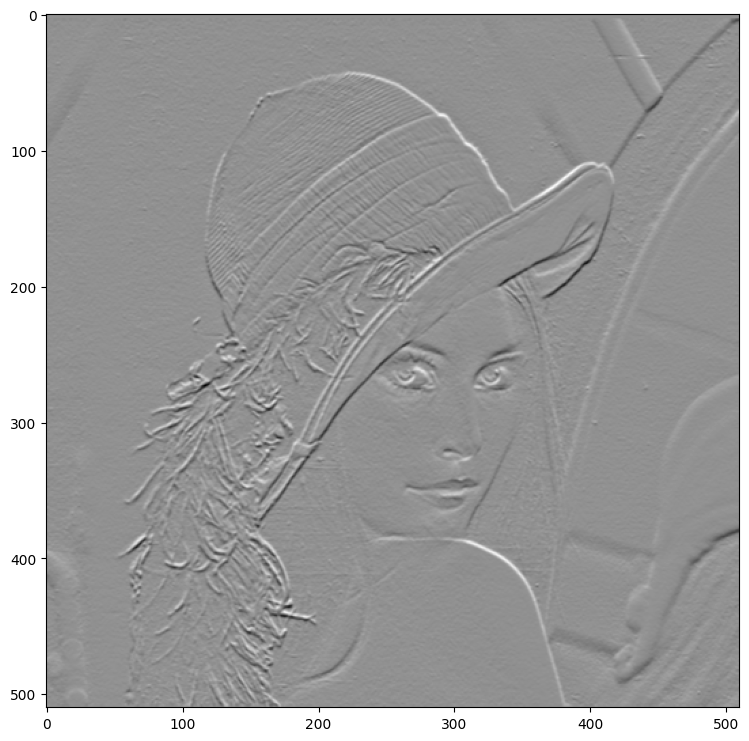

In [ ]:
K = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]]) # Change this to a Gaussian Blur (3X3)
output = corr2d(X,K)
plt.imshow(output, cmap = 'gray')
plt.show()

## Miscellaneous 1:

Our implementation was slow, So, let's do the same operation with pytorch this time.

(_Hint: run this code multiple times, and see multiple types of features being selected_)

In pytorch, the Convolution is done as:

$$
out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k = 0}^{C_{in}-1}{weight(C_{out_j},k)*input(N_i,k)}
$$
Where, $*$ is 2D cross-correlation operator. _(From pytorch docs)_


X = [batch_size, channels, height, width]: torch.Size([1, 1, 512, 512])
Shape of out: torch.Size([1, 1, 510, 510])


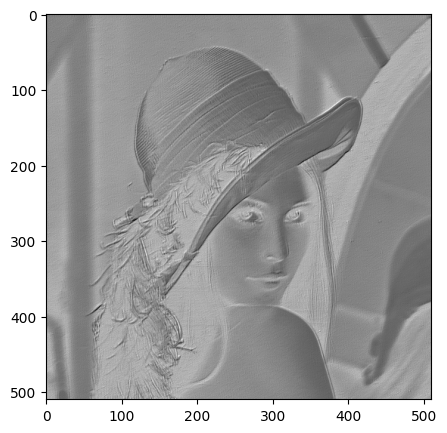

In [ ]:
my_conv = torch.nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 3)
my_conv.weight.requires_grad = False
X = np.expand_dims(img_gray, axis = 0)
X = np.expand_dims(X, axis = 0)
X = torch.from_numpy(X.astype("float32"))
print(f"X = [batch_size, channels, height, width]: {X.shape}")
out = my_conv(X)
print(f"Shape of out: {out.shape}")
plt.rcParams["figure.figsize"] = (10,5)
plt.imshow(out[0][0].detach().numpy(), cmap = 'gray')
plt.show()

In [ ]:
print(f"Our Parameters")
print(list(my_conv.parameters()))

Our Parameters
[Parameter containing:
tensor([[[[-0.0025,  0.1788, -0.2743],
          [-0.2453, -0.1284,  0.0894],
          [-0.0066,  0.2643, -0.0296]]]]), Parameter containing:
tensor([0.0882], requires_grad=True)]


So, if we use the same values, the output should be the same right ?

Shape of Output: torch.Size([510, 510])


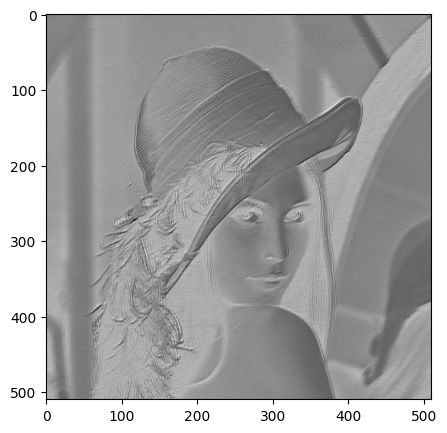

In [ ]:
my_new_K = list(my_conv.parameters())[0]
X = torch.from_numpy(img_gray)
output = corr2d(X,my_new_K[0][0])
output = output + list(my_conv.parameters())[1][0].item() # We are adding the bias term at the last
print(f"Shape of Output: {output.shape}")
plt.imshow(output.detach().numpy(), cmap = 'gray')

### Question:
1. If we have input channels of 5 and output channels of 10, how many Kernels would we have (in pytorch)? and How many Biases?

Can you show in code?

## Padding and Stride

We've seen that convolution operation decreases the image size. But By how much ??

Our Lenna Image was initially $512 \times 512$ which decreased to $510 \times 510$ when we did a $3\times 3$ convolution.

What would happen if we did a $5 \times 5$ convolution ?

Could we apply convolution such that the dimensions remain the same ?

### Padding

In applying convolutional layers, we tend to lose pixels on the perimeter of our image. We use smaller kernels so the loss is small but this adds up.

So, by how much do our outputs decrease in accordance to our kernel and what can we do to keep it consistent?

## Let's Create a Neural Network

1. Dataset Used: Fashion MNIST
2. Classification Type = Categorical
3. Architecture: LeNet

### Small Background about Architecture:
LeNet was published in 1998 by LeCun for the purpose of recognizing handwritten digits in images. It achieved error rate of less than 1% per digit and was eventually adapted to recognize digits in ATM machines.

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

train_data = torchvision.datasets.FashionMNIST("./data", train = True, transform = transform, download = True)
val_data = torchvision.datasets.FashionMNIST("./data", train = False, transform = transform, download = True)

# Creating dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 16, shuffle = False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print('Training set has {} instances'.format(len(train_data)))
print('Validation set has {} instances'.format(len(val_data)))

100%|██████████| 26421880/26421880 [00:06<00:00, 3878663.99it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201434.97it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2485798.67it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15534012.22it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


### It's always good to visualize the data first.

Sneaker Trouser Bag Shirt Trouser Dress Dress Shirt Trouser Shirt Pullover Bag Shirt T-shirt/top Sneaker Pullover


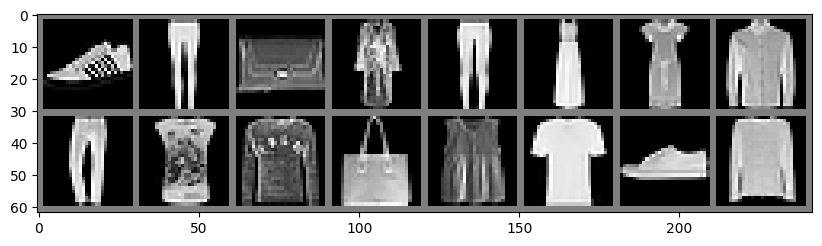

In [ ]:
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
images, labels = next(data_iter)
img_grid = torchvision.utils.make_grid(images)
# because image is 1 channel only
img = img_grid.permute(1,2,0)
img = img /2 + 0.5 # unnormalize (std and mean)
plt.imshow(img, cmap = 'gray')
print(" ".join(classes[labels[j]] for j in range(16)))

In [ ]:
print(labels)
type(labels)
labels.dtype

tensor([7, 1, 8, 6, 1, 3, 3, 6, 1, 6, 2, 8, 6, 0, 7, 2])


torch.int64

## Pooling

A typical layer of CNN consists of 3 stages:
1. Perform several convolutions in parallel, get linear activations
2. Each linear activation is run through non-linear activations eg. ReLU
3. Use a pooling function to modify the output of the layer further.

torch.Size([16, 1, 28, 28])


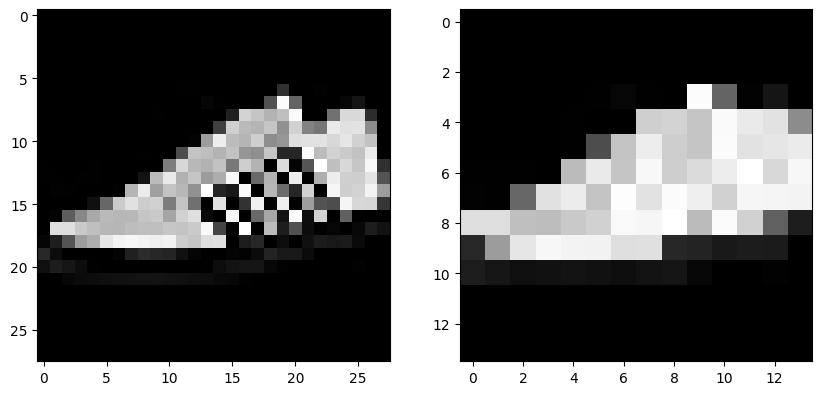

In [ ]:
print(images.shape)
img = images[0]
sample_pooling_layer = torch.nn.MaxPool2d(2,2)
pooling_output = sample_pooling_layer(img)
fig, ax = plt.subplots(1,2)
ax[0].imshow(img[0], cmap = 'gray')
ax[1].imshow(pooling_output[0], cmap = 'gray')
plt.show()

Here, we can see that Pooling Keeps the overall structure similar but reduces the number of features significantly.

Can you rotate the image and send the rotated image to a pooling layer. What changes did you see?

### Create the Network

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
class LeNet(nn.Module):
    """
    We are using sigmoid activations instead of ReLU because it's what was used at that time.
    Same for AveragePooling too.

    In the final layer, we will not use the Gaussian Decoder as in the original LeNet-5 architecture
    """
    @staticmethod
    def get_conv_block(n_inputs, n_outputs, kernel_size, padding, stride, activation = nn.Sigmoid):
        net = nn.Sequential(
            nn.Conv2d(n_inputs, n_outputs, kernel_size = kernel_size, padding = padding),
            activation(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
        )
        return net

    @staticmethod
    def get_dense_block(n_inputs, n_outputs, activation = nn.Sigmoid):
        net = nn.Sequential(
            nn.Linear(n_inputs, n_outputs),
            activation(),
        )
        return net

    def __init__(self, num_classes = 10):
        super().__init__()
        self.conv_1 = LeNet.get_conv_block(n_inputs = 1,
                                           n_outputs = 6,
                                           kernel_size = 5,
                                           padding = 2,
                                           stride = 1)
        self.conv_2 = LeNet.get_conv_block(n_inputs = 6, # n_inputs = n_outputs from previous
                                           n_outputs = 16,
                                           kernel_size = 5,
                                           padding = "valid",
                                           stride = 1)
        self.dense_1 = LeNet.get_dense_block(n_inputs = 400,
                                             n_outputs = 200)
        self.dense_2 = LeNet.get_dense_block(n_inputs = 200,
                                             n_outputs = 84)
        self.dense_out = nn.Linear(84, num_classes)
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = torch.flatten(x, start_dim = 1) # We don't want to change the batch dimension
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_out(x)

        return F.log_softmax(x, dim = 1)

# It is a good practice to always test your neural network with a random input before training
# Makes debugging easier
my_input = np.random.random((4,1,28,28)).astype("float32")
my_input = torch.from_numpy(my_input)
print(my_input.shape)
my_net = LeNet(10)
dummy_outputs = my_net(my_input)

## Let's see the loss on dummy inputs:
loss_fn = torch.nn.CrossEntropyLoss()
dummy_labels = torch.tensor([1,2,3,4])
loss_fn(dummy_outputs, dummy_labels)

torch.Size([4, 1, 28, 28])


tensor(2.2583, grad_fn=<NllLossBackward0>)

In [ ]:
# training loop:
import tqdm
device  = torch.device('cuda:0')
model = LeNet(10)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
def train_epoch(epoch_no):
    running_loss = 0
    curr_loss = 0
    tq_loader = tqdm.tqdm(train_loader)
    for i, data in enumerate(tq_loader):
        tq_loader.set_description(f"Loss: {curr_loss}")
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        curr_loss = loss.item()
        running_loss += curr_loss

    return running_loss/i

for ep_no in range(20):
    train_epoch(ep_no)

Loss: 2.2849268913269043:  40%|███▉      | 1487/3750 [00:14<00:22, 101.37it/s]


KeyboardInterrupt: 

#### Questions to Ponder.
Can you experiment with ReLU, MaxPooling<br>
Do they increase the performance of the network ?

## Miscellaneous 2:

Discrete convolution can be viewed as multiplication by a matrix, but the matrix has several entries constrained.
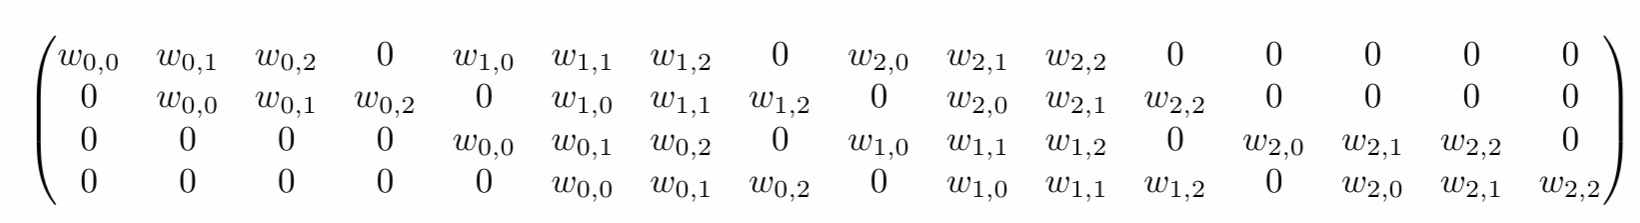

Let's see it in action.

Let us consider that we have a $3 \times 3$ Input and a $2 \times 2$ Kernel.
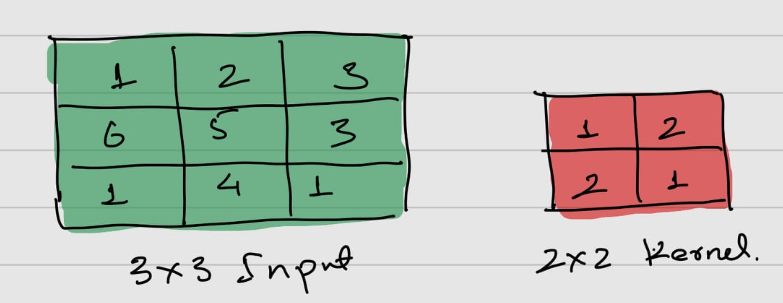

The Convolution Matrix would be:

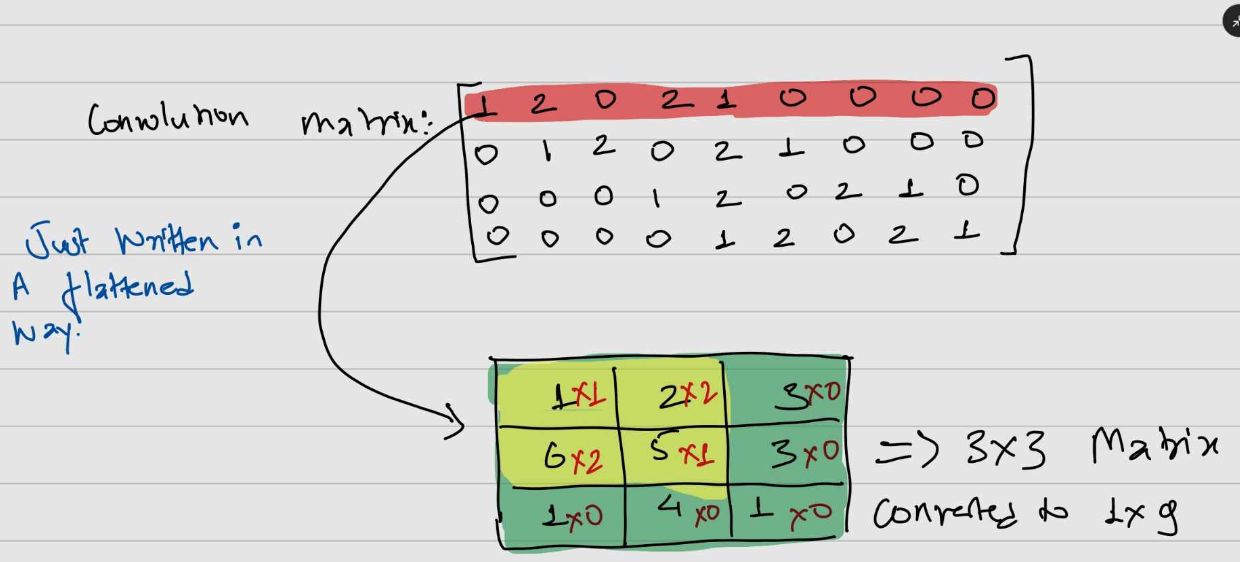

In [ ]:
def corr2d(X,K):
    conv_matrix = torch.tensor([[K[0,0], K[0,1], 0, K[1,0], K[1,1], 0, 0, 0, 0],
                                [0, K[0,0], K[0,1], 0, K[1,0], K[1,1], 0, 0, 0],
                                [0, 0, 0, K[0,0], K[0,1], 0, K[1,0], K[1,1], 0],
                                [0, 0, 0, 0, K[0,0], K[0,1], 0, K[1,0], K[1,1]],])
    print(conv_matrix)
    print(conv_matrix.shape)
    X = torch.flatten(X)
    return X@conv_matrix.T
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

Question to Ponder

What would the Convolution Matrix look like for a $3 \times 3$ Kernel?

## References:
1. http://d2l.ai
2. http://deeplearningbook.org